In [1]:
!pip install opencv-python-headless matplotlib numpy ipywidgets

# ==============================================================================
# Imports
# ==============================================================================
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects, binary_erosion, binary_dilation
from skimage.color import rgb2lab, lab2rgb
from skimage.util import img_as_float
from skimage.transform import resize
from scipy.spatial import distance
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans, AgglomerativeClustering
from collections import Counter, defaultdict
import math
from ipywidgets import interact, IntSlider, FloatSlider, Button, VBox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.3 MB/s eta 0:00:00


# Image Color extraction code

The goal of the code below is to take an image from the user with or without a background and decrease the color pallete of the image to a user defined subset of colors; since in real life for each frame we will only have a limited amount / color of paper which we can cut.
I went about this a combination of k-means and mean-shift clustering in the lab color space of the image to produce a pallete that capture the colors that are most dominant in the image while keeping less prevalent but vibrant colors of the image.

## Utility functions and image import

In [32]:
# -----------------------------------------------------------------------------
# Utility Functions
# -----------------------------------------------------------------------------
def display_image(image_array, title="Image", size=(6,6)):
    """
    Display a given image array (NumPy array) with a title.
    For images with transparency, a white background is used.
    """
    if image_array.shape[-1] == 4:
        rgb = image_array[..., :3].copy()
        alpha = image_array[..., 3]
        rgb[alpha==0] = [255, 255, 255]
        img_to_show = rgb
    else:
        img_to_show = image_array
    plt.figure(figsize=size)
    plt.imshow(img_to_show)
    plt.title(title)
    plt.axis('off')
    plt.show()

def get_unique_colors(image):
    """
    Return a list of unique RGB colors in the input image.
    If the image is already flattened (i.e. shape (N,3)), it returns unique rows.
    """
    arr = image if image.ndim == 2 else image.reshape(-1, image.shape[2])
    return np.unique(arr, axis=0)


def display_palette(palette, title="Palette"):
    """
    Displays a list of RGB colors as swatches in a single row.
    """
    if not palette:
        print(f"No colors to display for {title}.")
        return
    swatch_height, swatch_width = 50, 50
    n_colors = len(palette)
    swatches = np.zeros((swatch_height, swatch_width * n_colors, 3), dtype=np.uint8)
    for i, color in enumerate(palette):
        swatches[:, i*swatch_width:(i+1)*swatch_width, :] = np.array(color, dtype=np.uint8)
    plt.figure(figsize=(max(n_colors, 8), 2))
    plt.imshow(swatches)
    plt.title(title)
    plt.axis('off')
    plt.show()


def checkered_bg(img):
  has_alpha = (img.mode in ('RGBA', 'LA'))

  if has_alpha:
      img_np = np.array(img)
      rgb_img = img_np[..., :3]           # extract RGB channels
      alpha_channel = img_np[..., 3]        # extract alpha channel
      fg_mask = alpha_channel > 0           # foreground mask from alpha

      # Get image dimensions
      height, width = rgb_img.shape[:2]

      # Adaptive tile size: 2% of the smaller dimension (ensuring at least 1 pixel)
      tile_size = max(1, int(min(height, width) * 0.02))

      # Define colors for checkered pattern
      color1 = np.array([255, 255, 255], dtype=np.uint8)  # white tile
      color2 = np.array([200, 200, 200], dtype=np.uint8)  # light gray tile

      # Create a checkered background using a vectorized approach:
      y, x = np.indices((height, width))
      checkerboard = ((x // tile_size + y // tile_size) % 2 == 0)
      background = np.where(checkerboard[..., None], color1, color2)

      # Composite the image: use rgb_img where alpha is present, else use checkered background
      display_img = np.where(fg_mask[..., None], rgb_img, background)
  else:
      img_np = np.array(img.convert('RGB'))  # ensure RGB format
      rgb_img = img_np
      fg_mask = np.ones(rgb_img.shape[:2], dtype=bool)  # all pixels are foreground
      display_img = rgb_img  # no modification needed



In [33]:

# -----------------------------------------------------------------------------
# Helper function to compute Lab distance for two RGB colors
# -----------------------------------------------------------------------------
def lab_distance(rgb1, rgb2):
    """
    Convert two RGB colors (0-255) to Lab (after scaling to [0,1]) and return the Euclidean distance.
    """
    # Convert to float and scale to [0,1]
    rgb1_arr = np.array([[list(rgb1)]], dtype=np.float64) / 255.0
    rgb2_arr = np.array([[list(rgb2)]], dtype=np.float64) / 255.0
    lab1 = rgb2lab(rgb1_arr)[0,0,:]
    lab2 = rgb2lab(rgb2_arr)[0,0,:]
    return np.linalg.norm(lab1 - lab2)

# -----------------------------------------------------------------------------
# Hierarchical clustering (reduce_palette_to_n_colors) using Lab space
# -----------------------------------------------------------------------------
def reduce_palette_to_n_colors(full_palette, target_n):
    """
    Reduce 'full_palette' to 'target_n' colors using Agglomerative Clustering in Lab space.
    """
    if target_n >= len(full_palette):
        return list(full_palette)

    # Convert palette to Lab space
    lab_palette = [rgb2lab(np.array([[list(c)]], dtype=np.float64)/255.0)[0,0,:] for c in full_palette]
    X = np.array(lab_palette, dtype=np.float64)

    clustering = AgglomerativeClustering(n_clusters=target_n, metric='euclidean', linkage='average')
    labels = clustering.fit_predict(X)

    # Compute mean color of each cluster
    new_colors_lab = [X[labels == i].mean(axis=0) for i in range(target_n)]

    # Convert back to RGB
    new_colors_rgb = [(np.clip(lab2rgb([[lab]]), 0, 1) * 255).astype(np.uint8)[0,0,:].tolist() for lab in new_colors_lab]
    return [tuple(rgb) for rgb in new_colors_rgb]

# -----------------------------------------------------------------------------
# find_nearest_color uses Lab distance for final recolor
# -----------------------------------------------------------------------------
def find_nearest_color(px, palette):
    """
    Find the nearest color to 'px' in the given palette using Lab distance.
    """
    return min(palette, key=lambda c: lab_distance(px, c))

# -----------------------------------------------------------------------------
# Modified: Merge palettes using Lab space for near-duplicate removal
# -----------------------------------------------------------------------------
def merge_palettes_remove_duplicates(palette1, palette2, threshold=5.0):
    """
    Merge two RGB palettes, removing near-duplicate colors using Lab distance.
    """
    merged = palette1 + palette2
    unique_colors = []
    for color in merged:
        if all(lab_distance(color, uc) >= threshold for uc in unique_colors):
            unique_colors.append(color)
    return unique_colors

# -----------------------------------------------------------------------------
# Modified: Recluster palette using K-Means in Lab space
# -----------------------------------------------------------------------------
def recluster_palette(color_list, final_k=10):
    """
    Apply K-Means clustering in Lab space to reduce colors to 'final_k'.
    """
    X = np.array([
        rgb2lab(np.array([[list(c)]], dtype=np.float64)/255.0)[0,0,:] for c in color_list
    ])
    kmeans = KMeans(n_clusters=final_k, random_state=42)
    kmeans.fit(X)
    centers_lab = kmeans.cluster_centers_
    centers_rgb = [(np.clip(lab2rgb([[lab]]), 0, 1) * 255).astype(np.uint8)[0,0,:].tolist() for lab in centers_lab]
    return [tuple(rgb) for rgb in centers_rgb]



In [34]:
# -----------------------------------------------------------------------------
# File Input (Google Colab friendly)
# -----------------------------------------------------------------------------
try:
    path_input = input("Enter file path to your image (or press Enter to upload): ").strip()
except Exception as e:
    print(f"Input failed: {e}")
    path_input = ""

if path_input:
    # Use provided path
    filename = path_input
    img = Image.open(filename)
else:
    # Prompt for upload in Google Colab
    print("Please upload your image file.")
    from google.colab import files
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    img = Image.open(filename)

Enter file path to your image (or press Enter to upload): /content/shinji.jpg


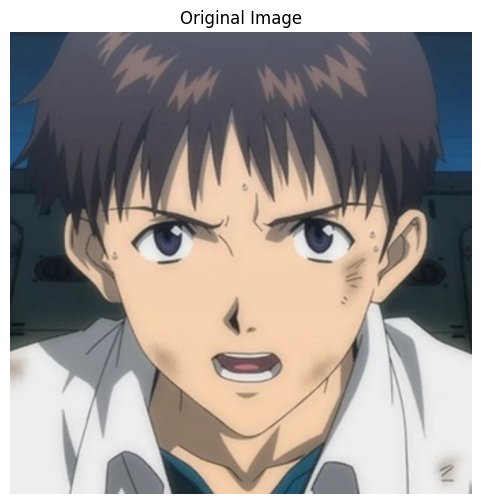

33598


In [35]:
# -----------------------------------------------------------------------------
# Step 2: Check alpha & prepare image for processing
# -----------------------------------------------------------------------------
has_alpha = (img.mode in ('RGBA', 'LA'))

if has_alpha:
    img_np = np.array(img)
    rgb_img = img_np[..., :3]           # extract RGB channels
    alpha_channel = img_np[..., 3]        # extract alpha channel
    fg_mask = alpha_channel > 0           # foreground mask from alpha

    # Get image dimensions
    height, width = rgb_img.shape[:2]

    # Adaptive tile size: 2% of the smaller dimension (ensuring at least 1 pixel)
    tile_size = max(1, int(min(height, width) * 0.02))

    # Define colors for checkered pattern
    color1 = np.array([255, 255, 255], dtype=np.uint8)  # white tile
    color2 = np.array([200, 200, 200], dtype=np.uint8)  # light gray tile

    # Create a checkered background using a vectorized approach:
    y, x = np.indices((height, width))
    checkerboard = ((x // tile_size + y // tile_size) % 2 == 0)
    background = np.where(checkerboard[..., None], color1, color2)

    # Composite the image: use rgb_img where alpha is present, else use checkered background
    display_img = np.where(fg_mask[..., None], rgb_img, background)
else:
    img_np = np.array(img.convert('RGB'))  # ensure RGB format
    rgb_img = img_np
    fg_mask = np.ones(rgb_img.shape[:2], dtype=bool)  # all pixels are foreground
    display_img = rgb_img  # no modification needed

# Show the loaded image
height, width = rgb_img.shape[:2]
display_image(display_img, title="Original Image")

# Note: rgb_img is still the one we want to work
print(len(get_unique_colors(display_img)))

## Obtaining the main colors in the image



### Meanshift in Lab space

After some experimentation I decided to use the mean shift algorithm in the Lab colorspace of the image to cluster the main colors in the image. We first scale down the image and only use a subset of those pixels to calculate the bandwith used in meanshift, changing these values might produce better results but it will take longer and MS is already initialization dependent.

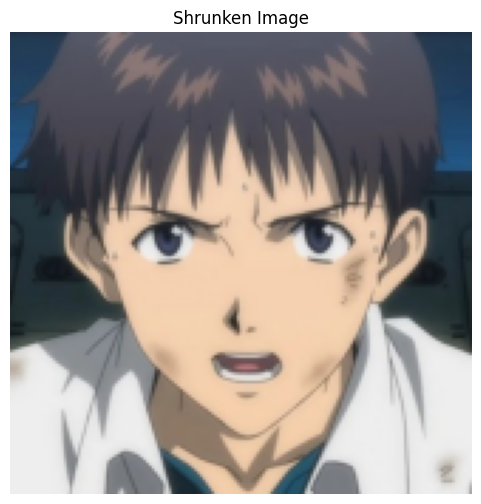

Estimating bandwidth for MeanShift on the shrunken image...
Estimated bandwidth = 6.98
Running MeanShift on the shrunken image...
MeanShift found 11 clusters.


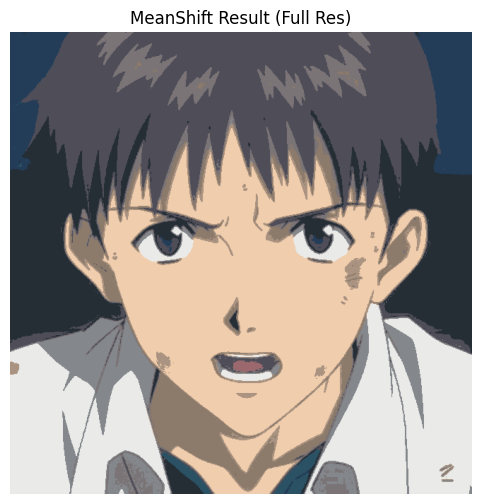

MeanShift palette has 11 colors.


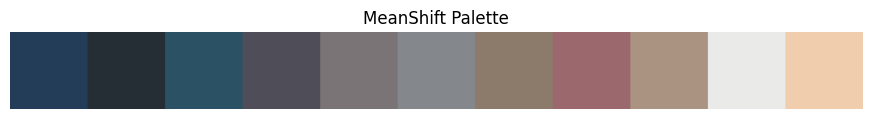

In [36]:
# -----------------------------------------------------------------------------
# Downscale, Convert to Lab, and MeanShift Clustering
# -----------------------------------------------------------------------------
scale_factor = 0.25 # keep small if big image
newH, newW = int(height * scale_factor), int(width * scale_factor)
shrunken_img = resize(rgb_img, (newH, newW), anti_aliasing=True, preserve_range=True).astype(np.uint8)
display_image(shrunken_img, title="Shrunken Image")

# Convert to Lab and prepare for clustering
lab_small = rgb2lab(shrunken_img)
pixels_lab_small = lab_small.reshape((-1, 3))

# Sample small portion for bandwidth estimation
sample_size = int(0.25 * pixels_lab_small.shape[0])
sample_indices = np.random.choice(pixels_lab_small.shape[0], sample_size, replace=False)
sample_data_small = pixels_lab_small[sample_indices]

print("Estimating bandwidth for MeanShift on the shrunken image...")
bandwidth = estimate_bandwidth(sample_data_small, quantile=0.1, n_samples=sample_size)
print(f"Estimated bandwidth = {bandwidth:.2f}")

# Run MeanShift
print("Running MeanShift on the shrunken image...")
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(pixels_lab_small)
labels_small = ms.labels_
cluster_centers_ms = ms.cluster_centers_
print(f"MeanShift found {len(np.unique(labels_small))} clusters.")

# Apply clusters to full-resolution image
lab_full = rgb2lab(rgb_img)
pixels_lab_full = lab_full.reshape((-1, 3))
dists = distance.cdist(pixels_lab_full, cluster_centers_ms)
closest_centers = np.argmin(dists, axis=1)
new_lab_img = cluster_centers_ms[closest_centers].reshape(lab_full.shape)
new_rgb_img = lab2rgb(new_lab_img)
new_rgb_img_255 = (np.clip(new_rgb_img, 0, 1) * 255).astype(np.uint8)

# Merge alpha if present
if has_alpha:
    mean_shift_img = np.dstack((new_rgb_img_255, alpha_channel))
    display_ms = new_rgb_img_255.copy()
    display_ms = np.where(fg_mask[..., None], display_ms, background)
else:
    mean_shift_img = new_rgb_img_255
    display_ms = mean_shift_img

display_image(display_ms, title="MeanShift Result (Full Res)")

# Extract palette from result
ms_unique_colors = get_unique_colors(new_rgb_img_255[fg_mask].reshape(-1, 3))
ms_palette = [tuple(c) for c in ms_unique_colors]
print(f"MeanShift palette has {len(ms_palette)} colors.")
display_palette(ms_palette, title="MeanShift Palette")


In [27]:
def optimized_recolor_image_to_palette(rgb_img, palette):
    """
    Reassign each pixel in 'rgb_img' to the closest color in 'palette' using a vectorized
    approach in Lab space.
    """
    H, W = rgb_img.shape[:2]
    lab_pixels = rgb2lab(rgb_img.astype(np.float64)/255.0).reshape(-1, 3)
    palette_arr = np.array(palette, dtype=np.uint8)
    palette_lab = rgb2lab(palette_arr[np.newaxis, ...].astype(np.float64)/255.0).reshape(-1, 3)
    nearest_indices = np.argmin(distance.cdist(lab_pixels, palette_lab), axis=1)
    return palette_arr[nearest_indices].reshape(H, W, 3)


How many final MS colors do you want? 11
Merging the MeanShift palette from 11 to 11 colors...
Palette is now 11 colors.


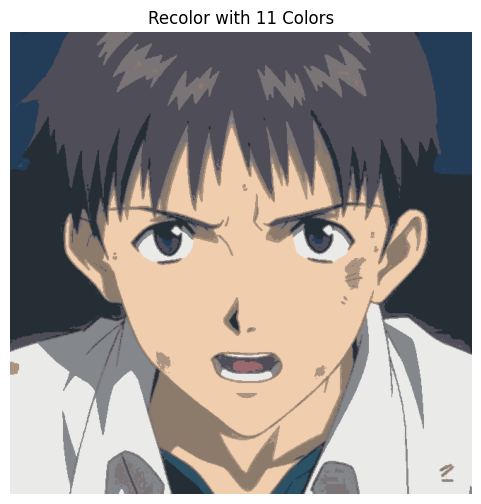

(Skipped recoloring for speed.) Using 11 colors after reduction.



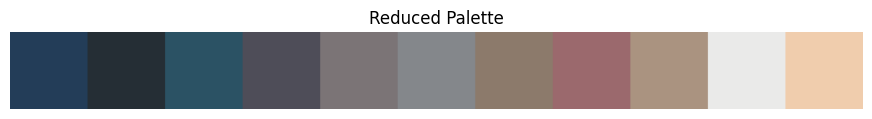

In [37]:
# -----------------------------------------------------------------------------
# Reduce MeanShift Palette to User-defined Number of Colors
# -----------------------------------------------------------------------------
user_n = int(input("How many final MS colors do you want? "))
print(f"Merging the MeanShift palette from {len(ms_palette)} to {user_n} colors...")

# Reduce using hierarchical clustering in Lab space

final_palette = reduce_palette_to_n_colors(ms_palette, user_n)
print(f"Palette is now {len(final_palette)} colors.")

# Optional: Skip slow pixel-wise recoloring and just use reduced palette for next stage
# If you want to preview the recolored image, uncomment below:
final_array = optimized_recolor_image_to_palette(mean_shift_img[..., :3] if has_alpha else mean_shift_img, final_palette)
if has_alpha:
     final_img_np = np.dstack((final_array, alpha_channel))
     reduced_ms_image = final_array.copy()
     reduced_ms_image[~fg_mask] = [255, 255, 255]
else:
     final_img_np = final_array
     reduced_ms_image = final_img_np
display_image(reduced_ms_image, title=f"Recolor with {user_n} Colors")

# Instead, just show the reduced palette
reduced_ms_palette = final_palette
print(f"(Skipped recoloring for speed.) Using {len(reduced_ms_palette)} colors after reduction.\n")
display_palette(reduced_ms_palette, title="Reduced Palette")


## K-means

Now we will also use K-means to calculate the most common colors in the image, the advtange of this is we can define the number of clusters however kmeans can kind of be considered as global mean shift so images with a taint or a heavy bakground color will kind of overpower the color intensity of less prevalent colors

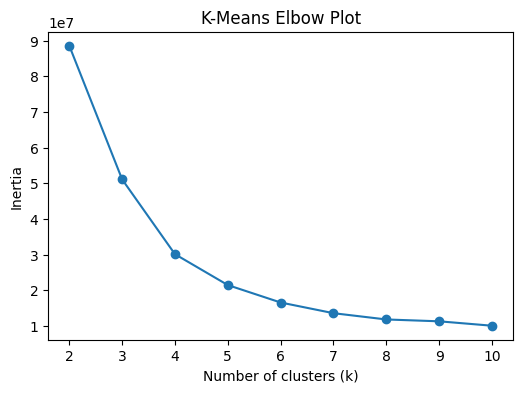

In [7]:
# -----------------------------------------------------------------------------
# Elbow Method: Determine a good 'k' by plotting inertia vs. k
# -----------------------------------------------------------------------------
k_values = range(2, 11)
inertias = []
pixels_lab = rgb2lab(display_img.astype(np.float64)/255.0).reshape((-1, 3))

for k in k_values:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(pixels_lab)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(6,4))
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("K-Means Elbow Plot")
plt.show()

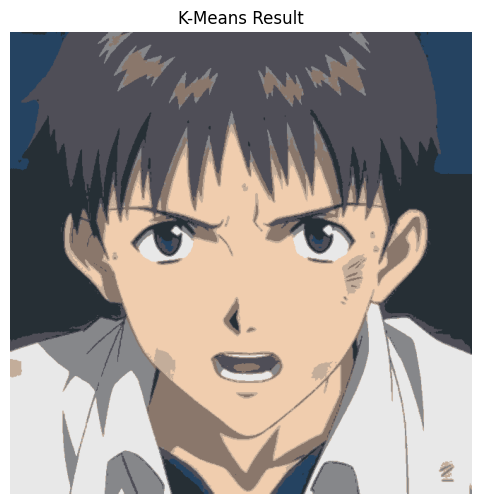

K-Means palette has 8 colors.


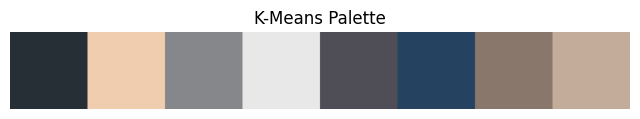

In [38]:
# -----------------------------------------------------------------------------
# Choose the number of clusters (e.g. after examining the elbow plot)
# -----------------------------------------------------------------------------
k = 8 # Change this as desired
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(pixels_lab)
labels_km = kmeans.labels_
cluster_centers_km = kmeans.cluster_centers_
cluster_centers_rgb = lab2rgb(cluster_centers_km.reshape(1, -1, 3)).reshape(-1, 3)

new_lab_img = cluster_centers_km[labels_km].reshape(lab_full.shape)
new_rgb_img = lab2rgb(new_lab_img)
new_rgb_img_255 = (np.clip(new_rgb_img, 0, 1) * 255).astype(np.uint8)

if has_alpha:
    kmeans_img = np.dstack((new_rgb_img_255, alpha_channel))
    display_km = new_rgb_img_255.copy()
    display_km = np.where(fg_mask[..., None], display_km, background)
else:
    kmeans_img = new_rgb_img_255
    display_km = kmeans_img

display_image(display_km, title="K-Means Result")
km_palette = (cluster_centers_rgb * 255).astype(np.uint8).tolist()
print(f"K-Means palette has {len(km_palette)} colors.")
display_palette(km_palette, title="K-Means Palette")


Combined palette length (before re-clustering) = 12
Final palette length (after re-clustering to 8) = 8


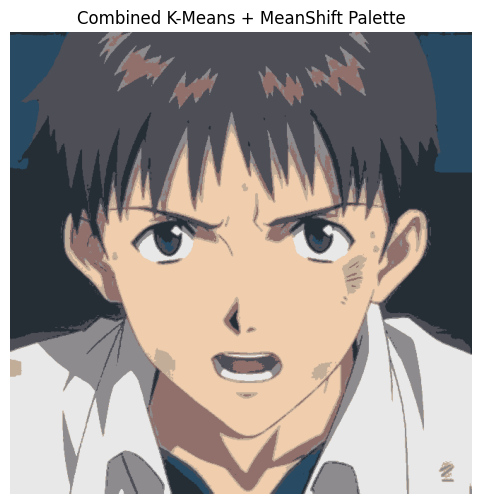

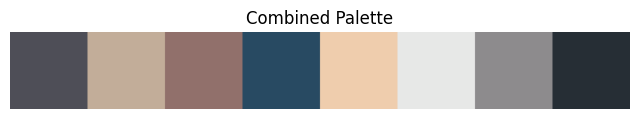

In [29]:
# -----------------------------------------------------------------------------
# Merge palettes and re-cluster using Lab distances
# -----------------------------------------------------------------------------
combined_palette = merge_palettes_remove_duplicates(km_palette, reduced_ms_palette, threshold=5.0)
print(f"Combined palette length (before re-clustering) = {len(combined_palette)}")

desired_k = 8  # Change as desired
final_palette = recluster_palette(combined_palette, final_k=desired_k)
print(f"Final palette length (after re-clustering to {desired_k}) = {len(final_palette)}")

# Recolor original image with final combined palette
final_quantized_img = optimized_recolor_image_to_palette(rgb_img, final_palette)

if has_alpha:
    final_img = np.dstack((final_quantized_img, alpha_channel))
    display_final = final_quantized_img.copy()
    display_final = np.where(fg_mask[..., None], display_final, background)
else:
    final_img = final_quantized_img
    display_final = final_quantized_img

display_image(display_final, title="Combined K-Means + MeanShift Palette")
display_palette(final_palette, title="Combined Palette")


In [39]:
final_choice = int(input("Which image / palette do you want to use MS(1), KM(2), or Combination(3)? "))
if final_choice == 1:
    display_final = reduced_ms_image
elif final_choice == 2:
    display_final = display_km
else:
    display_final = final_quantized_img

Which image / palette do you want to use MS (1), KM(2), or Combination(3)? 1


Found 11 unique colors in the image.


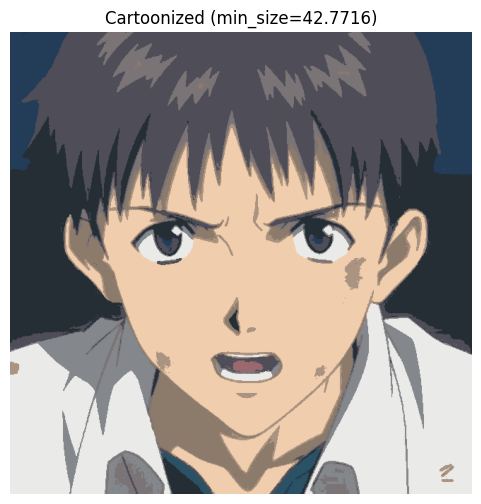

True

In [40]:
def remove_small_splotches_colorwise(img, min_size=1):
    """
    Removes small isolated color patches in an image by reassigning them to the most
    frequent neighboring color. Operates per unique color label.
    Optimized version uses find_objects and binary_dilation to reduce per-pixel loops.
    """

    cleaned = img.copy()
    # Find unique colors by flattening the color channels
    unique_colors = np.unique(cleaned.reshape(-1, cleaned.shape[-1]), axis=0)

    print(f"Found {len(unique_colors)} unique colors in the image.")

    for color in unique_colors:
        # Create mask for the current color
        mask = np.all(cleaned == color, axis=-1)
        # Label connected regions in the mask
        labeled_mask, num_labels = label(mask, structure=np.ones((3, 3)))
        # Get slices for each connected component
        slices = find_objects(labeled_mask)
        if slices is None:
            continue

        for label_id, slc in enumerate(slices, start=1):
            # Extract the region for the current label within its bounding box
            region = (labeled_mask[slc] == label_id)
            region_size = np.sum(region)
            if region_size < min_size:
                # Compute the dilated region and subtract the original region to get neighbors
                dilated = binary_dilation(region, structure=np.ones((3, 3)))
                neighbor_mask = dilated & (~region)
                # Get neighbor coordinates relative to the slice, then convert to image coordinates
                neighbor_coords = np.argwhere(neighbor_mask)
                if neighbor_coords.size == 0:
                    continue
                # Adjust coordinates to full image indices
                neighbor_coords[:, 0] += slc[0].start
                neighbor_coords[:, 1] += slc[1].start
                # Gather neighbor colors
                neighbor_colors = [tuple(cleaned[r, c]) for r, c in neighbor_coords]
                if neighbor_colors:
                    most_common_color = Counter(neighbor_colors).most_common(1)[0][0]
                    # Update all pixels in the connected region at once
                    region_coords = np.argwhere(labeled_mask[slc] == label_id)
                    for r_offset, c_offset in region_coords:
                        cleaned[r_offset + slc[0].start, c_offset + slc[1].start] = most_common_color
    return cleaned

# Determine a size threshold for removing splotches
percent_size = 1 # percent of total image area
min_size_threshold = percent_size * (width * height) / (100 * 100)

# Apply cartoon-style cleanup
cartoonized_img = remove_small_splotches_colorwise(display_final, min_size=min_size_threshold)
if has_alpha:
    final_img = np.dstack((cartoonized_img, alpha_channel))
    display_final = cartoonized_img.copy()
    display_final = np.where(fg_mask[..., None], display_final, background)
else:
    final_img = cartoonized_img
    display_final = cartoonized_img

display_image(display_final, title=f"Cartoonized (min_size={min_size_threshold})")

cv2.imwrite('img.png', display_final)